# Autotalker Data Analysis

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 29.01.2023
- **Date of Last Modification:** 08.03.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../autotalker")

In [3]:
import argparse
import os
import random
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
import torch
from matplotlib.pyplot import rc_context

from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps)

### 1.2 Define Parameters

In [28]:
## Dataset
dataset = "eel_fish_mouse_brain"
n_neighbors = 12

## Model
# AnnData Keys
counts_key = "counts"
cell_type_key = "Clusters"
adj_key = "spatial_connectivities"
spatial_key = "spatial"
gp_names_key = "autotalker_gp_names"
active_gp_names_key = "autotalker_active_gp_names"
gp_targets_mask_key = "autotalker_gp_targets"
gp_sources_mask_key = "autotalker_gp_sources"
latent_key = "autotalker_latent"
condition_key = "batch"

# Architecture
active_gp_thresh_ratio = 0.03
gene_expr_recon_dist = "nb"
n_cond_embed = 180
log_variational = True # counts as input
n_layers_encoder = 1
conv_layer_encoder = "gcnconv" # gatv2conv gcnconv

# Trainer
n_epochs = 40 # 40
n_epochs_all_gps = 20 # 20
lr = 0.001
query_cond_embed_lr = 0.01
lambda_edge_recon = 1000. # 0.3 # 1., 0.01
lambda_gene_expr_recon = 1. # 1. # 1., 0.01, 0.0033
lambda_group_lasso = 0.1 # 0.01
lambda_l1_masked = 0.1 # 0.01 0.0033
edge_batch_size = 256 # 64, 128, 256, 512
node_batch_size = 32 # 8, 16, 32, 64

## Others
random_seed = 42
load_timestamp = None

### 1.3 Run Notebook Setup

In [12]:
sc.set_figure_params(figsize=(6, 6))
sns.set_style("whitegrid", {'axes.grid' : False})

In [13]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [14]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

In [47]:
# Set experiment
experiment = mlflow.set_experiment("batch_integration_mouse_organogenesis_imputed")
mlflow.log_param("timestamp", current_timestamp)

'08032023_180125'

### 1.4 Configure Paths and Create Directories

In [15]:
# Define paths
figure_folder_path = f"../figures/{dataset}/analysis/{current_timestamp}"
model_artifacts_folder_path = f"../artifacts/{dataset}/analysis/{current_timestamp}"
gp_data_folder_path = "../datasets/gp_data" # gene program data
srt_data_folder_path = "../datasets/srt_data" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(model_artifacts_folder_path, exist_ok=True)

## 2. Data

### 2.1 Load Data & Compute Spatial Neighbor Graph

In [30]:
adata = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}.h5ad")

In [31]:
# Compute (separate) spatial neighborhood
sq.gr.spatial_neighbors(adata,
                        coord_type="generic",
                        spatial_key=spatial_key,
                        n_neighs=n_neighbors)
# Make adjacency matrix symmetric
adata.obsp["spatial_connectivities"] = adata.obsp["spatial_connectivities"].maximum(
    adata.obsp["spatial_connectivities"].T)

### 2.2 Explore Data

Exploring dataset eel_fish_mouse_brain.
Number of nodes (cells): 127591
Number of node features (genes): 440


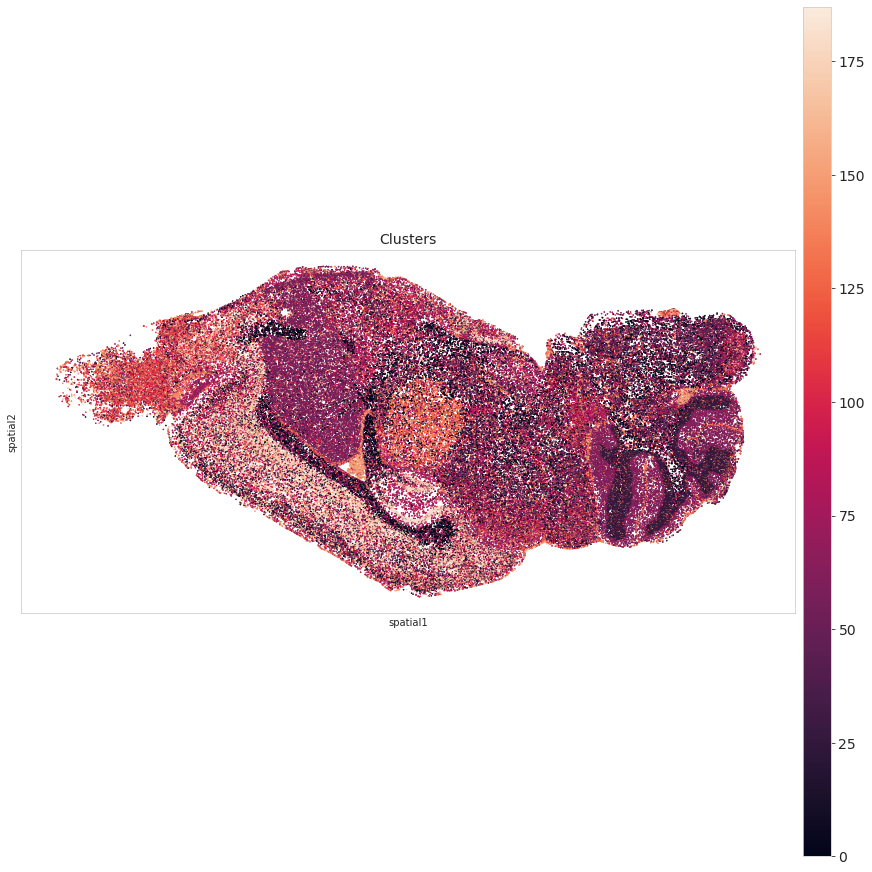

In [32]:
print(f"Exploring dataset {dataset}.")
print(f"Number of nodes (cells): {adata.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata.layers['counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata, color=cell_type_key, shape=None, figsize=(12, 12))

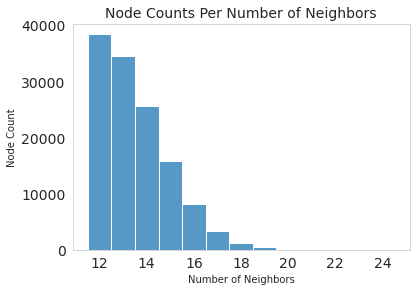

Average number of edges per node: 13.52.
Number of total edges: 862451.


In [33]:
# Plot histogram of node counts per number of neighbors
ax = sns.histplot(np.squeeze(np.asarray(adata.obsp['spatial_connectivities'].sum(axis=0))),
                  discrete=True)
ax.set_title("Node Counts Per Number of Neighbors")
ax.set_ylabel("Node Count")
ax.set_xlabel("Number of Neighbors")
fig = ax.figure
fig.savefig(f"{figure_folder_path}/node_counts_per_n_neighs_sample1.png",
            bbox_inches="tight")
plt.show()

avg_edges_per_node = round(adata.obsp['spatial_connectivities'].sum(axis=0).mean(), 2)
print(f"Average number of edges per node: {avg_edges_per_node}.")
n_edges = int(sp.triu(adata.obsp['spatial_connectivities'], k=1).sum())
print(f"Number of total edges: {n_edges}.")

## 3. Autotalker Model with Prior Knowledge Cell-Cell-Interaction (CCI) Gene Programs (GPs)

### 3.1 Prepare Prior Knowledge CCI GP Mask

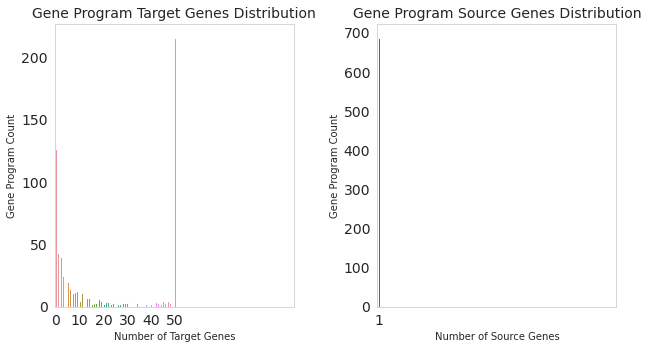

In [34]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_genes_ratio=0.01,
    max_n_target_genes_per_gp=50,
    load_from_disk=False,
    save_to_disk=False,
    file_path=nichenet_ligand_target_mx_file_path,
    plot_gp_gene_count_distributions=True)

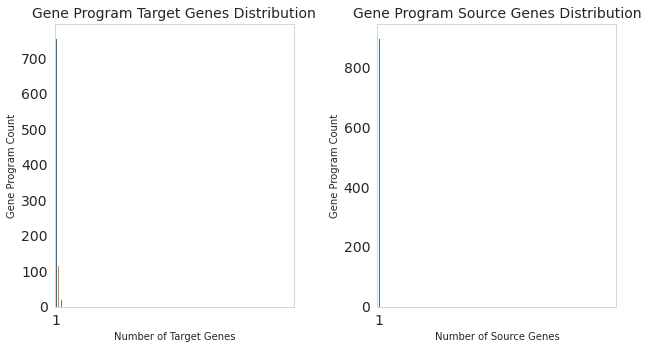

In [35]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_lr_interactions_file_path)

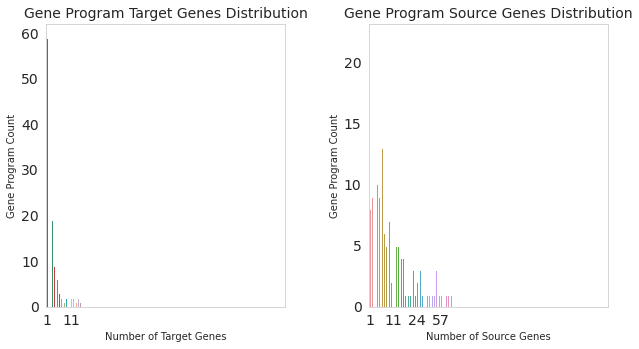

In [36]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps/",
    species="mouse",
    genes_uppercase=True)

In [37]:
# Combine gene programs into one dictionary
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)
# combined_gp_dict.update(mebocost_gp_dict)

In [38]:
# Filter and combine gene programs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(combined_new_gp_dict)}.")

Removing GP 'TNFSF4_ligand_receptor_GP' as it is a subset of GP 'TNFSF4_ligand_targetgenes_GP'.
Removing GP 'TGFB1_ligand_receptor_GP' as it is a subset of GP 'TGFB1_ligand_targetgenes_GP'.
Removing GP 'BMP2_ligand_receptor_GP' as it is a subset of GP 'BMP2_ligand_targetgenes_GP'.
Removing GP 'EDN1_ligand_receptor_GP' as it is a subset of GP 'EDN1_ligand_targetgenes_GP'.
Removing GP 'EDN3_ligand_receptor_GP' as it is a subset of GP 'EDN3_ligand_targetgenes_GP'.
Removing GP 'GCG_ligand_receptor_GP' as it is a subset of GP 'GCG_ligand_targetgenes_GP'.
Removing GP 'HCRT_ligand_receptor_GP' as it is a subset of GP 'HCRT_ligand_targetgenes_GP'.
Removing GP 'GRP_ligand_receptor_GP' as it is a subset of GP 'GRP_ligand_targetgenes_GP'.
Removing GP 'NTF3_ligand_receptor_GP' as it is a subset of GP 'NTF3_ligand_targetgenes_GP'.
Removing GP 'AVP_ligand_receptor_GP' as it is a subset of GP 'AVP_ligand_targetgenes_GP'.
Removing GP 'PROK1_ligand_receptor_GP' as it is a subset of GP 'PROK1_ligand_tar

In [39]:
# Add the gene program dictionary as binary masks to the adata for model training
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata,
    genes_uppercase=True,
    gp_targets_mask_key="autotalker_gp_targets",
    gp_sources_mask_key="autotalker_gp_sources",
    gp_names_key="autotalker_gp_names",
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None,
    filter_genes_not_in_masks=False)

# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata.uns["autotalker_gp_names"])

In [41]:
# Summarize gene programs
print(f"Number of gene programs with probed genes: {len(adata.uns['autotalker_gp_names'])}.")
print(f"Example gene programs: {random.sample(list(adata.uns['autotalker_gp_names']), 5)}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_gp_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_gp_sources'].sum()}.")

Number of gene programs with probed genes: 422.
Example gene programs: ['FGF21_ligand_targetgenes_GP', 'FGF17_ligand_targetgenes_GP', 'SCT_ligand_receptor_GP', 'CNTN2_ligand_targetgenes_GP', 'HSP90B1_ligand_targetgenes_GP'].
Number of gene program target genes: 647.
Number of gene program source genes: 119.


### 3.2 Initialize, Train & Save Model

In [48]:
# Initialize model
model = Autotalker(adata,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=condition_key,
                   cond_embed_injection=["gene_expr_decoder",
                                         "graph_decoder"],
                   n_cond_embed=n_cond_embed,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_layers_encoder=n_layers_encoder,
                   conv_layer_encoder=conv_layer_encoder,
                   n_hidden_encoder=n_hidden_encoder,
                   log_variational=log_variational)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 440, n_cond_embed_input: 0, n_layers: 1, n_hidden: 422, n_latent: 422, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
COSINE SIM GRAPH DECODER -> n_cond_embed_input: 180, n_output: 422, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 422, n_cond_embed_input: 180, n_addon_input: 0, n_output: 880


In [ ]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_group_lasso=lambda_group_lasso,
            lambda_l1_masked=lambda_l1_masked,
            edge_batch_size=edge_batch_size,
            node_batch_size=node_batch_size,
            # mlflow_experiment_id=experiment.experiment_id,
            verbose=True)

--- INITIALIZING TRAINER ---
Number of training nodes: 114832
Number of validation nodes: 12759
Number of training edges: 776206
Number of validation edges: 86245

--- MODEL TRAINING ---


In [ ]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/sample1",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

## 4. Analysis

### 4.1 Load Model

In [ ]:
# Load trained model
if load_timestamp is not None:
    model_artifacts_load_folder_path = f"../artifacts/{dataset}/analysis/{load_timestamp}"
else:
    model_artifacts_load_folder_path = model_artifacts_folder_path
    
model = Autotalker.load(dir_path=f"{model_artifacts_load_folder_path}/prior_knowledge_gp_mask",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

In [ ]:
# Check number of active gene programs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

In [ ]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key, key_added=latent_key)
sc.tl.umap(model.adata, neighbors_key=latent_key)

### 4.1 Cell Types in Spatial and Physical Space

In [ ]:
# Create subplot of cell-type annotations in physical and latent space
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))
title = fig.suptitle(t="Cell Types in Physical and Latent Space",
                     x=0.85,
                     y=0.925,
                     fontsize=20)
sc.pl.spatial(adata=model.adata,
              color=[cell_type_key],
              spot_size=0.03,
              title="Physical Space",
              ax=axs[0],
              show=False)
sc.pl.umap(adata=model.adata,
           color=[cell_type_key],
           title="Latent Space",
           ax=axs[1],
           show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1.225, 0.625))
axs[0].get_legend().remove()
axs[1].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0, hspace=0.1)
fig.savefig(f"{figure_folder_path}/cell_types_physical_latent_space.png",
            bbox_extra_artists=(lgd, title),
            bbox_inches="tight")
plt.show()

### 4.2 Latent Leiden Clusters in Latent and Physical Space

In [ ]:
# Compute latent Leiden clustering
resolution = 0.3

sc.tl.leiden(adata=model.adata,
             resolution=resolution,
             random_state=random_seed,
             key_added=f"latent_leiden_{str(resolution)}",
             adjacency=model.adata.obsp[f"{latent_key}_connectivities"])

In [ ]:
# Create subplot of latent Leiden cluster annotations in physical and latent space
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))
title = fig.suptitle(t="Latent Leiden Cluster Annotations in Latent and Physical Space",
                     x=0.85,
                     y=0.925,
                     fontsize=20)
sc.pl.umap(adata=model.adata,
           color=[f"latent_leiden_{str(resolution)}"],
           title=f"Latent Space",
           ax=axs[0],
           show=False)
sc.pl.spatial(adata=model.adata,
              color=[f"latent_leiden_{str(resolution)}"],
              spot_size=0.03,
              title=f"Physical Space",
              ax=axs[1],
              show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1.025, 0.7))
axs[0].get_legend().remove()
axs[1].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0, hspace=0.1)
fig.savefig(f"{figure_folder_path}/latent_leiden_clusters_latent_physical_space.png",
            bbox_extra_artists=(lgd, title),
            bbox_inches="tight")
plt.show()

### 4.3 GP Enrichments

#### 4.3.1 Cell-type GP Enrichments

In [ ]:
differential_gp_scores_key = "autotalker_cell_type_differential_gp_scores"
n_top_up_gps = 10
n_top_down_gps = 10

##### 4.3.1.1 Explore All GPs Across All Categories

In [ ]:
# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_unique_gps = model.compute_differential_gp_scores(cat_key=cell_type_key,
                                                      adata=model.adata,
                                                      selected_gps=None, # ["BMP7_ligand_targetgenes_GP", "CD24_ligand_targetgenes_GP"],
                                                      selected_cats=None, # ["Cardiomyocytes", "Presomitic mesoderm"]
                                                      gp_scores_weight_normalization=False,
                                                      comparison_cats="rest",
                                                      n_sample=10000,
                                                      key_added=differential_gp_scores_key,
                                                      n_top_up_gps_retrieved=n_top_up_gps,
                                                      n_top_down_gps_retrieved=n_top_down_gps,
                                                      seed=random_seed)

In [ ]:
# Display top upregulated gene programs
top_up_gp_df = model.adata.uns[differential_gp_scores_key][:n_top_up_gps]
display(top_up_gp_df)

In [ ]:
# Display top downregulated gene programs
top_down_gp_df = model.adata.uns[differential_gp_scores_key][-n_top_down_gps:][::-1]
display(top_down_gp_df)

In [ ]:
fig = sc.pl.dotplot(model.adata,
                    top_unique_gps,
                    groupby=cell_type_key,
                    dendrogram=True, 
                    title="Differential GP Scores Per Cell-type",
                    return_fig=True)

# Save and display plot
fig.savefig(f"{figure_folder_path}/differential_gp_scores_per_cell_type_all_categories.png")
plt.show()

In [ ]:
top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()
top_genes = []

for gp in top_gps:
    top_genes.append(
        model.compute_gp_gene_importances(selected_gp=gp)["gene"][0])

In [ ]:
# Plot selected gene program latent scores
fig, axs = plt.subplots(nrows=n_top_up_gps+n_top_down_gps, ncols=3, figsize=(18, 4*len(top_gps)))
title = fig.suptitle(t="Differential GP Scores, Corresponding Cell-Types and Most Important GP Genes in Latent Space",
                     x=0.55,
                     y=0.96,
                     fontsize=20)
for i in range(len(top_gps)):
    sc.pl.umap(model.adata, color=top_gps[i], color_map="magma", ax=axs[i, 0], show=False)
    sc.pl.umap(model.adata,
               color=[cell_type_key],
               color_map="magma",
               groups=top_cats[i],
               ax=axs[i, 1],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    sc.pl.umap(model.adata,
               color=top_genes[i],
               color_map="binary",
               ax=axs[i, 2],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    
# Save and display plot
fig.savefig(f"{figure_folder_path}/cell_type_gp_scores_cell_types_most_important_genes_all_categories.png",
            bbox_extra_artists=(title,),
            bbox_inches="tight")
plt.show()

##### 4.3.1.2 Explore All GPs Across Specific Categories

In [ ]:
selected_cats = ["Erythroid", "Cardiomyocytes"]

In [ ]:
# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_unique_gps = model.compute_differential_gp_scores(cat_key=cell_type_key,
                                                      adata=model.adata,
                                                      selected_gps=None,
                                                      selected_cats=selected_cats,
                                                      gp_scores_weight_normalization=False,
                                                      comparison_cats="rest",
                                                      n_sample=1000,
                                                      key_added=differential_gp_scores_key,
                                                      n_top_up_gps_retrieved=n_top_up_gps,
                                                      n_top_down_gps_retrieved=n_top_down_gps,
                                                      seed=random_seed)

In [ ]:
# Display top upregulated gene programs
top_up_gp_df = model.adata.uns[differential_gp_scores_key][:n_top_up_gps]
display(top_up_gp_df)

In [ ]:
# Display top downregulated gene programs
top_down_gp_df = model.adata.uns[differential_gp_scores_key][-n_top_down_gps:][::-1]
display(top_down_gp_df)

In [ ]:
fig = sc.pl.dotplot(model.adata,
                    top_unique_gps,
                    groupby=cell_type_key,
                    dendrogram=True, 
                    title="Differential GP Scores Per Cell-type",
                    return_fig=True)

# Save and display plot
fig.savefig(f"{figure_path}/differential_gp_scores_per_cell_type_specific_categories.png")
plt.show()

In [ ]:
top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()
top_genes = []

for gp in top_gps:
    top_genes.append(
        model.compute_gp_gene_importances(selected_gp=gp)["gene"][0])

In [ ]:
# Plot selected gene program latent scores
fig, axs = plt.subplots(nrows=n_top_up_gps+n_top_down_gps, ncols=3, figsize=(18, 4*len(top_gps)))
title = fig.suptitle(t="Differential GP Scores, Corresponding Cell-Types and Most Important GP Genes in Latent Space",
                     x=0.55,
                     y=0.96,
                     fontsize=20)
for i in range(len(top_gps)):
    sc.pl.umap(model.adata, color=top_gps[i], color_map="magma", ax=axs[i, 0], show=False)
    sc.pl.umap(model.adata,
               color=[cell_type_key],
               color_map="magma",
               groups=top_cats[i],
               ax=axs[i, 1],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    sc.pl.umap(model.adata,
               color=top_genes[i],
               color_map="binary",
               ax=axs[i, 2],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    
# Save and display plot
fig.savefig(f"{figure_path}/cell_type_gp_scores_cell_types_most_important_genes_specific_categories.png",
            bbox_extra_artists=(title,),
            bbox_inches="tight")
plt.show()

##### 4.3.1.3 Explore Specific GPs

In [ ]:
selected_gps = ["BMP7_ligand_targetgenes_GP", "EPOR_ligand_receptor_GP"]

In [ ]:
# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_unique_gps = model.compute_differential_gp_scores(cat_key=cell_type_key,
                                                      adata=model.adata,
                                                      selected_gps=selected_gps,
                                                      selected_cats=None,
                                                      gp_scores_weight_normalization=False,
                                                      comparison_cats="rest",
                                                      n_sample=1000,
                                                      key_added=differential_gp_scores_key,
                                                      n_top_up_gps_retrieved=n_top_up_gps,
                                                      n_top_down_gps_retrieved=n_top_down_gps,
                                                      seed=random_seed)

In [ ]:
# Display top upregulated gene programs
top_up_gp_df = model.adata.uns[differential_gp_scores_key][:n_top_up_gps]
display(top_up_gp_df)

In [ ]:
# Display top downregulated gene programs
top_down_gp_df = model.adata.uns[differential_gp_scores_key][-n_top_down_gps:][::-1]
display(top_down_gp_df)

In [ ]:
fig = sc.pl.dotplot(model.adata,
                    top_unique_gps,
                    groupby=cell_type_key,
                    dendrogram=True, 
                    title="Differential GP Scores Per Cell-type",
                    return_fig=True)

# Save and display plot
fig.savefig(f"{figure_path}/differential_gp_scores_per_cell_type_specific_gps.png")
plt.show()

In [ ]:
top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()
top_genes = []

for gp in top_gps:
    top_genes.append(
        model.compute_gp_gene_importances(selected_gp=gp)["gene"][0])

In [ ]:
# Plot selected gene program latent scores
fig, axs = plt.subplots(nrows=n_top_up_gps+n_top_down_gps, ncols=3, figsize=(18, 4*len(top_gps)))
title = fig.suptitle(t="Differential GP Scores, Corresponding Cell-Types and Most Important GP Genes in Latent Space",
                     x=0.55,
                     y=0.96,
                     fontsize=20)
for i in range(len(top_gps)):
    sc.pl.umap(model.adata, color=top_gps[i], color_map="magma", ax=axs[i, 0], show=False)
    sc.pl.umap(model.adata,
               color=[cell_type_key],
               color_map="magma",
               groups=top_cats[i],
               ax=axs[i, 1],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    sc.pl.umap(model.adata,
               color=top_genes[i],
               color_map="binary",
               ax=axs[i, 2],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    
# Save and display plot
fig.savefig(f"{figure_path}/cell_type_gp_scores_cell_types_most_important_genes_specific_gps.png",
            bbox_extra_artists=(title,),
            bbox_inches="tight")
plt.show()

#### 4.3.2 Spatial GP Enrichments

Same analysis can be done with spatial cluster labels instead of cell-types.

#### 4.3.3 GP Gene Importances

In [ ]:
selected_gp = ["BMP7_ligand_targetgenes_GP"]

In [ ]:
gene_importances_df = model.compute_gp_gene_importances(
    selected_gp="BMP7_ligand_receptor_GP",
    adata=None)

display(gene_importances_df)

In [ ]:
genes = list(gene_importances_df["gene"])

for gene in genes:
    sc.pl.umap(model.adata,
               color=gene,
               color_map="binary",
               legend_loc="on data",
               na_in_legend=False)

## 5. Learn De-Novo CCI GPs

### 5.1 Initialize, Train & Save Model

In [ ]:
model = Autotalker.load(dir_path=f"{model_artifacts_path}/autotalker_combined_gps_{current_timestamp}",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        n_addon_gps=10,
                        gp_names_key=gp_names_key,
                        freeze_non_addon_weights=True)

In [ ]:
model.train(n_epochs=n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_l1_addon=lambda_l1_addon)

In [ ]:
model.save(dir_path=f"{model_artifacts_path}/autotalker_combined_denovo_gps_{current_timestamp}",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

Same analysis can be repeated with de-novo gene programs.